<a href="https://colab.research.google.com/github/tarod13/OptimalControl/blob/main/OptimalControl_DP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Programming project

First, we'll load the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

seed = 23
np.random.seed(seed)

## 1. Methods 

### 1.1 Trajectory simulations
We need to defined methods that allow simulating trajectories based on the differential equation $\dot{x}(t)=Ax(t)+Bu(t)$ that specify the system being controlled.

We will use the Dormand-Prince method to simulate the dynamics. For this, we will define an integration step method that receives as input the state-action pair $(x(t),u(t))$ and approximates the corresponding adjusted derivative $\frac{dx}{dt}$. Then, we introduce a second method that executes several times the step, to produce a trajectory where $x[k+1]\leftarrow x[k]+\frac{dx}{dt}\Delta t$.  

In [2]:
# Dormand-Prince integration step
def step_DormandPrince(f,t,x,h,u,f_args):

    k1 = f(t,x,u,f_args)
    x2 = x + h*(1./5.*k1)
    k2 = f(t + 1./5.*h, x2, u, f_args)
    x3 = x + h*(3./40.*k1 + 9./40.*k2)
    k3 = f(t + 3./10*h, x3, u, f_args)
    x4 = x + h*(44./45.*k1 - 56./15.*k2 + 32./9.*k3)
    k4 = f(t + 4./5.*h, x4, u, f_args)
    x5 = x + h*(19372./6561.*k1 - 25360./2187.*k2 + 64448./6561.*k3 - 212./729.*k4)
    k5 = f(t + 8./9.*h, x5, u, f_args)
    x6 = x + h*(9017./3168.*k1 - 355./33.*k2 + 46732./5247.*k3 + 49./176.*k4 - 5103./18656.*k5)
    k6 = f(t + h, x6, u, f_args)

    dx_dt = 35./384.*k1 + 500./1113.*k3 + 125./192.*k4 - 2187./6784.*k5 + 11./84.*k6    
    return dx_dt

In [82]:
# Dormand-Prince simulation with forced input
def simulate_trajectory_DormandPrince(f, t, t_k, x0, f_args,
                                      policy='simple', NA=21):
    N = len(t)
    x_last = x0.copy()
    x = [x0]
    u0, a0, s0 = x2u(x0, policy, NA)
    u, a, s = [u0], [a0], [s0]
    j = 0

    for i in range(0, N-1):
        dx_dt = step_DormandPrince(f,t[i],x_last,t[i+1]-t[i],u[j],f_args)
        dt = t[i+1]-t[i]
        x_last = x_last + dx_dt*dt

        if t[i+1] >= t_k[j+1]:
          j += 1
          x.append(x_last.copy())
          u_last, a_last, s_last = x2u(x_last, policy, NA)
          u.append(u_last)
          a.append(a_last)
          s.append(s_last)

    return np.stack(x), np.stack(s), np.stack(a), np.stack(u)

# # Dormand-Prince simulation with forced input
# def simulate_trajectory_DormandPrince(f, t, t_k, x0, f_args):
#     N = len(t)
#     x = [x0]
#     u0, a0, s0 = x2u(x0)
#     u, a, s = [u0], [a0], [s0]
#     j = 0    
#     for i in range(0, N-1):
#         dx_dt = step_DormandPrince(f,t[i],x[i],t[i+1]-t[i],u[i],f_args)
#         dt = t[i+1]-t[i]
#         x.append(x[i] + dx_dt*dt)
#         if t[i+1] > t_k[j+1]:
#           j += 1
#           u_ip1, a_ip1, s_ip1 = x2u(x[i+1])
#           u.append(u_ip1)
#           a.append(a_ip1)
#           s.append(s_ip1)
#         else:
#           u.append(u[i])
#           a.append(a[i])
#           s.append(s[i])
#     return np.stack(x), np.stack(s), np.stack(a), np.stack(u)

In [4]:
# Define system dynamics
def system_ode(t, x, u, args):
  A = args['A']; B = args['B']
  xdot = np.einsum('ij,kj->ki',A,x) + np.einsum('ij,kj->ki',B,u)  
  return xdot

### 1.2 Conversion methods and initial policy
We need to discretize the states to apply the tabular version of the DP algortihms. Also, to control the system from the policy we will need to convert discrete actions into control signals. 

In [5]:
# State in original coordinates to DP discrete state
def x2s(x, x_min=-1.0, x_max=1.0, NS=101):
  x_clip = x.clip(x_min, x_max-(x_max-x_min)/NS)
  x_unit = (x_clip - x_min) / (x_max-x_min)
  s_float = x_unit * NS
  s = np.floor(s_float).astype('int')
  return s  

In [6]:
# Action taken by initial policy
def simple_policy(state, NS=101, NA=21):
  s_0 = (NS-1)//2
  a_0 = (NA-1)//2
  if state[0] == s_0 and state[1] == s_0:
    return a_0
  elif state[0] > s_0 and state[1] >= s_0:
    return 0
  elif state[0] >= s_0 and state[1] < s_0:
    return a_0+2
  elif state[0] < s_0 and state[1] <= s_0:
    return NA-1
  elif state[0] <= s_0 and state[1] > s_0:
    return a_0-2
  else:
    print(state[0], state[1])
    raise NameError('Invalid state')

In [7]:
# Initial policy that takes state to origin
def s2a_simple_policy(s, NS=101):
  n_s = s.shape[0]
  a_list = [simple_policy(state) for state in s.tolist()]
  a = np.array(a_list).reshape(-1,1)
  return a

In [8]:
# DP discrete action to control signal 
def a2u(a, u_min=-1.0, u_max=1.0, NA=21):
  a_unit = a.astype('float') / float(NA-1)
  u = a_unit * (u_max-u_min) + u_min
  return u

In [39]:
# State to control signal
def x2u(x, policy='simple', NA=21):
  s = x2s(x)
  if policy == 'simple':
    a = s2a_simple_policy(s)
  elif policy == 'random':
    a = np.random.randint(NA, size=(s.shape[0],1))
  else:
    raise NameError('undefined policy')
  u = a2u(a)
  return u, a, s

### 1.3 DP methods 

In [89]:
# Initialize J table
def init_J_table_empty(NS=101):
  J_table = np.zeros((NS,NS))
  return J_table.copy()

def generate_init_states(n_points, x_min=-1.0, x_max=1.0):
  x0 = np.random.rand(n_points, 2)
  x0_scaled = x0 * (x_max - x_min) + x_min
  return x0_scaled 

def init_J_table(NS=101, n_trajectories=100, dt_sim=0.01, dt=0.04):
  J_table = init_J_table_empty(NS)
  N_table = np.zeros((NS,NS))
  x0 = generate_init_states(n_trajectories)
  t = np.arange(0,100,dt_sim)
  t_k = np.arange(0,100+dt,dt)
  
  x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0,ode_args)
  s0 = s[0,:,:]
  
  for i in range(0, x0.shape[0]):
    trajectory = (x[:,i,:], s[:,i,:], np.squeeze(a[:,i,:], 1), np.squeeze(u[:,i,:], 1))
    J = calculate_J_trajectory(trajectory, J_table, dt=dt)
    
    N_new = N_table[s0[i,0], s0[i,1]] + 1
    N_table[s0[i,0], s0[i,1]] = N_new
    J_table[s0[i,0], s0[i,1]] += (J - J_table[s0[i,0], s0[i,1]]) / N_new

  return J_table.copy(), N_table.copy()

def init_Q_table(J_table, NS=101, NA=21, n_points=100, dt_sim=0.01, dt=0.04):
  Q_table = np.zeros((NS,NS,NA))
  NSA_table = np.zeros((NS,NS,NA))
  x0 = generate_init_states(n_points)
  t = np.arange(0,dt+dt_sim,dt_sim)
  t_k = np.arange(0,dt+dt,dt)
  
  x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0,ode_args,
                                                 policy='random')
  s0 = s[0,:,:]
  a0 = a[0,:,:]
  
  for i in range(0, x0.shape[0]):
    trajectory = (x[:,i,:], s[:,i,:], np.squeeze(a[:,i,:], 1), np.squeeze(u[:,i,:], 1))
    J = calculate_J_trajectory(trajectory, J_table, dt=dt)
    
    N_new = NSA_table[s0[i,0], s0[i,1], a0[i,0]] + 1
    NSA_table[s0[i,0], s0[i,1], a0[i,0]] = N_new
    Q_table[s0[i,0], s0[i,1], a0[i,0]] += (J - Q_table[s0[i,0], s0[i,1], a0[i,0]]) / N_new

  return Q_table.copy(), NSA_table.copy()


def update_tables(J_table, Q_table, NS=101, NA=21, n_points=100, dt_sim=0.01, dt=0.04):
  pi = Q_table.argmin(2)
  NSA_table = np.zeros((NS,NS,NA))
  x0 = generate_init_states(n_points)
  
  t = np.arange(0,dt+dt_sim,dt_sim)
  t_k = np.arange(0,dt+dt,dt)
  
  x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0,ode_args,
                                                 policy='random')
  s0 = s[0,:,:]
  a0 = a[0,:,:]
  
  for i in range(0, x0.shape[0]):
    trajectory = (x[:,i,:], s[:,i,:], np.squeeze(a[:,i,:], 1), np.squeeze(u[:,i,:], 1))
    J = calculate_J_trajectory(trajectory, J_table, dt=dt)
    
    N_new = NSA_table[s0[i,0], s0[i,1], a0[i,0]] + 1
    NSA_table[s0[i,0], s0[i,1], a0[i,0]] = N_new
    Q_table[s0[i,0], s0[i,1], a0[i,0]] += (J - Q_table[s0[i,0], s0[i,1], a0[i,0]]) / N_new

  return Q_table.copy(), NSA_table.copy()

In [49]:
# Calculate cost-to-go J for given trajectory (tuple with lists x, s, a, and u)
def calculate_J_trajectory(trajectory, J_table, mode='time-fuel', 
                           w_fuel=5.0, dt=0.01):
  J = 0.0
  finished = False
  x, s, a, u = trajectory

  for i, (state, state_discrete, action, control) in enumerate(zip(x,s,a,u)):
    if mode == 'time-fuel':
      
      if state_discrete[0]==0 and state_discrete[1]==0:
        finished = True
      
      if (i+1) < len(x):
        J = J + (1.0 + w_fuel * abs(control))*dt
      else:
        J = J + J_table[state_discrete[0], state_discrete[1]]
      
      if finished:
        break

    else:
      raise NameError('Undefined mode')

  return J

## 2. Initial simulation with simple policy
We test our methods simulating three different initial conditions, with 2 different timesteps.

In [12]:
x0 = np.array([[0.5, 0.83], [-0.5, -0.83], [0.45, -0.1]])
A = np.array([[0.0,1.0],[0.0,0.0]])
B = np.array([[0.0],[1.0]])
ode_args = {'A': A.copy(), 'B': B.copy()}

KeyboardInterrupt: ignored

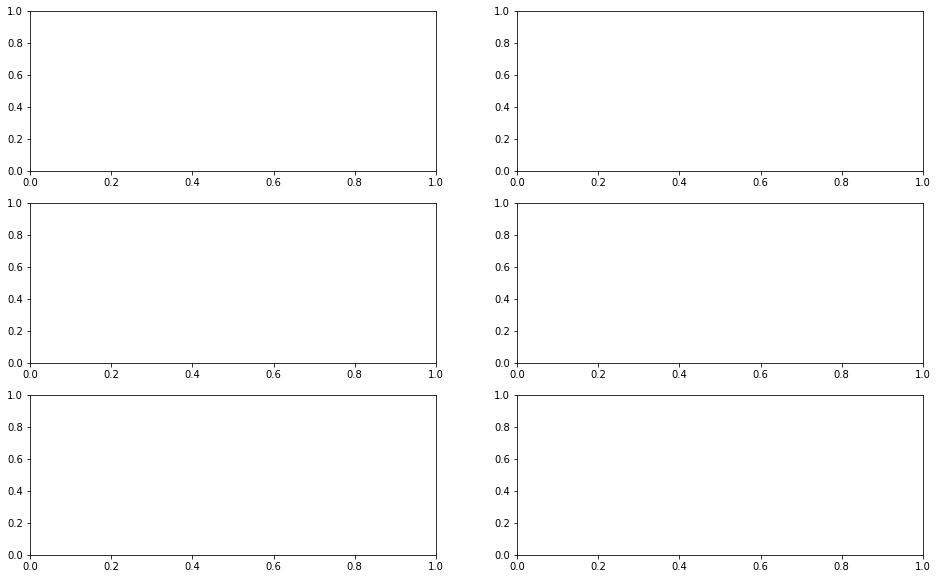

In [96]:
fig, ax = plt.subplots(3,2, figsize=(16,10))
for dt_sim in [0.001, 0.01]:
  dt = 0.04
  t = np.arange(0.0,75.0,dt_sim)
  t_k = np.arange(0.0,75.0+dt,dt)  
  x, s, a, u = simulate_trajectory_DormandPrince(system_ode,t,t_k,x0,ode_args)
  k = np.arange(0,len(x))
  for i in range(0, 1): 
    label_ = "dt=%.0e"%dt_sim+" (ej "+str(i)+")"   
    ax[0,0].plot(k, x[:,i,0], '-', ms=1, label=label_)
    ax[1,0].plot(k, x[:,i,1], '-', ms=1, label=label_)
    ax[2,0].plot(k, u[:,i,0], 'o', ms=1, label=label_)
    ax[0,1].plot(k, s[:,i,0], 'o', ms=1, label=label_)
    ax[1,1].plot(k, s[:,i,1], 'o', ms=1, label=label_)
    ax[2,1].plot(k, a[:,i,0], 'o', ms=1, label=label_)
ax[2,0].set_xlabel('Step $k$ (0.04s)')
ax[2,1].set_xlabel('Step $k$ (0.04s)')
ax[0,0].set_ylabel('$x_1(k\Delta t)$')
ax[0,1].set_ylabel('$s_1[k]$')
ax[1,0].set_ylabel('$x_2(k\Delta t)$')
ax[1,1].set_ylabel('$s_2[k]$')
ax[2,0].set_ylabel('$u(k\Delta t)$')
ax[2,1].set_ylabel('$a[k]$')
for i in range(0,3):
  for j in range(0,2):
    ax[i,j].grid()
    ax[i,j].legend(fontsize=10)
plt.show()
plt.close() 

KeyboardInterrupt: ignored

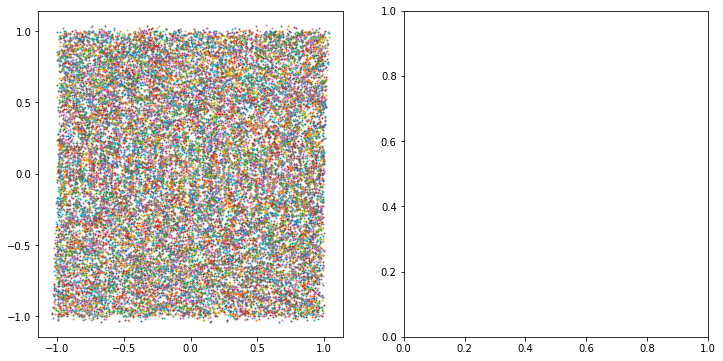

In [95]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

for i in range(0, x0.shape[0]): 
  ax[0].plot(x[:,i,0], x[:,i,1], 'o', ms=1)
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_xlabel(r'x_1(t)')
ax[0].set_ylabel(r'x_2(t)')

for i in range(0, x0.shape[0]): 
  ax[1].plot(s[:,i,0], s[:,i,1], 'o', ms=1)
ax[1].set_xlim([0,101])
ax[1].set_ylim([0,101])
ax[1].set_xlabel(r'$s_1(t)$')
ax[1].set_ylabel(r'$s_2(t)$')

for i in range(0, 2):
  ax[i].grid() 
plt.show()
plt.close() 

We can see that in all the cases the initial policy is successful in changing the state of the system to the origin. Also, it seems that precision is not heavily affected by increasing the time step $\Delta t$ from $0.001$ to $0.01$. Thus, we will fix this hyperparameter to 0.01.

In [50]:
J_table = init_J_table_empty()
J_test = []
for i in range(0, x0.shape[0]):
  trajectory = (x[:,i,:], s[:,i,:], np.squeeze(a[:,i,:], 1), 
                np.squeeze(u[:,i,:], 1))
  J_test.append(calculate_J_trajectory(trajectory, J_table, w_fuel=5.0, dt=0.04))
print("Cost-to-go J: ", J_test)

Cost-to-go J:  [140.4800000000008, 140.4800000000008, 110.28000000000581]


In addition, we estimated the cost for the 3 different trajectories. We can see that the first 2 have the same cost, given that they are symmetric, while the third one is comparatively low, given that the initial state $x(0)$ is closer to the origin.

# 3. DP
## 3.1 Initial evaluation for the policy $\mu_0$

We will 

In [51]:
J_table, N_table = init_J_table(n_trajectories=40000, dt_sim=0.01, dt=0.04)

In [90]:
Q_table, NSA_table = init_Q_table(J_table, n_points=10**7)

In [100]:
# Uncomment to store
# np.savetxt('J_mu0.csv', J_table, delimiter=',')
# np.savetxt('N_mu0.csv', N_table, delimiter=',')
# pickle.dump(Q_table, open('Q_mu0.p', mode='wb'))

# Uncomment to load
# J_table = np.loadtxt('J_mu0.csv', delimiter=',')
# Q_table = pickle.load(open('Q_mu0.p', mode='rb'))

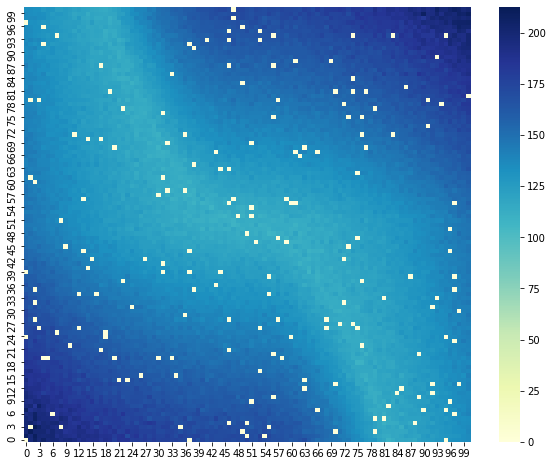

In [74]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(Q_table[:,:,10], ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
plt.show()
plt.close()

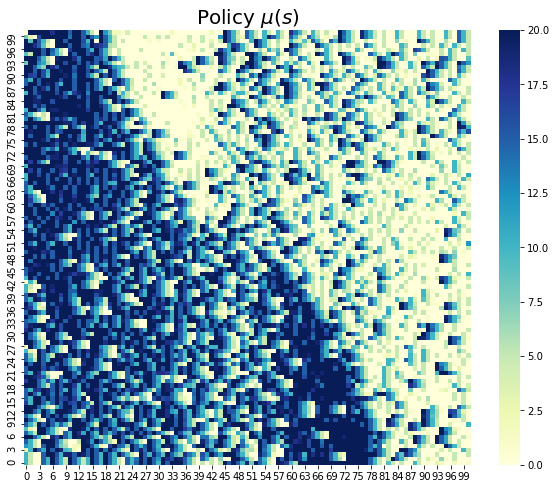

In [97]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
sns_ax = sns.heatmap(Q_table.argmin(axis=2), ax=ax, cmap='YlGnBu')
sns_ax.invert_yaxis()
plt.title('Policy $\mu(s)$', fontsize=20)
plt.show()
plt.close()